# NPLM Test notebook

## Imports

In [1]:
import torch 
import h5py
import os 
import sys

import scipy.stats as stats
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep

In [2]:
sys.path.insert(0, "/home/lai/nplm/src")
from plot_utils import plot_ref_data, plot_ref_data_reco, plot_loss_history
from analysis_utils import compute_df, produce_bins, save_binning, load_binning
from nn_utils import NPLMnetwork, loss_function

## Config

In [3]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
hep.style.use(hep.style.CMS)

## Constants

In [5]:
# Set random seed
SEED = 1231244
torch.manual_seed(SEED)
np.random.seed(SEED)

# Plotting parameters
FONTSIZE  = 24
FIGSIZE   = (10, 8)
RATIOSIZE = (10, 10)
PALETTE_1 = [
    "#1f77b4", # 0
    "#4876bf", # 1 
    "#6c74c5", # 2
    "#8f6fc6", # 3
    "#b067c0", # 4
    "#cd5fb4", # 5
    "#e657a3", # 6
    "#f9528d", # 7
    "#ff5474", # 8
    "#ff5d58", # 9
    "#ff6c3a", # 10
    "#ff7f0e", # 11
]
PALETTE_2 = [
    "#494B69", # 0
    "#695D7A", # 1
    "#9F5B72", # 2
    "#D8707C", # 3
    "#FDA85A", # 4
    "#FDCD5A", # 5
]
PALETTE_3 = [
    "midnightblue",   # 0
    "#1f78b4",        # 1
    "lightseagreen",  # 2
    "mediumseagreen", # 3
    "darkseagreen",   # 4
]

# Statistics                                                                                                                                                   
N_REF      = 200000
N_BKG      = 2000
N_SIG      = 10       
SIG_LOC    = 6.4
SIG_STD    = 0.16
# Samples weights N_D/N_R
N_R        = N_REF
N_D        = N_BKG

# Training parameters
N_EPOCHS   = 200000
PATIENCE   = 5000

# Network parameters
N_INPUTS     = 1
N_OUTPUTS    = 1
ARCHITECTURE = [N_INPUTS, 4, N_OUTPUTS]
WCLIP        = 9
ACTIVATION   = torch.nn.Sigmoid()


PLOT_PATH = "./plots/"
if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)
    
DATA_PATH = "./data/"
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

## Classes

## Functions

## NPLM

### Generate 1D data

In [6]:
# poisson fluctuate the number of events in each sample
N_bkg_p = int(torch.distributions.Poisson(rate=N_BKG).sample())
N_sig_p = int(torch.distributions.Poisson(rate=N_SIG).sample())

# the reference rate will not have nuisance parameters
feature_ref_dist = torch.distributions.Exponential(rate=1)

# the data rate will have nuisance parameters   
feature_bkg_dist = torch.distributions.Exponential(rate=1)
feature_sig_dist = torch.distributions.Normal(loc=SIG_LOC, scale=SIG_STD)

In [7]:
feature_ref  = feature_ref_dist.sample((N_REF,1))
feature_data = torch.cat(
    (
        feature_bkg_dist.sample((N_bkg_p, 1)),
        feature_sig_dist.sample((N_sig_p, 1))
    )
)

feature = torch.cat((feature_ref, feature_data), dim=0)

target_ref  = torch.zeros((N_REF, 1))
target_data = torch.ones((N_bkg_p + N_sig_p, 1))

target = torch.cat((target_ref, target_data), dim=0)

weights_ref  = torch.ones((N_REF, 1)) * (N_D / N_R)
weights_data = torch.ones((N_bkg_p + N_sig_p, 1))

weights = torch.cat((weights_ref, weights_data), dim=0)

# concatenate the weights to the target
target = torch.cat((target, weights), dim=1)

### Plot 1D data

In [8]:
# bins = load_binning(path=DATA_PATH, name="binning_1dexpon.h5")
bins = produce_bins(data=feature_ref, method="simple", bins_range=(0, 10), bins_width=0.25)

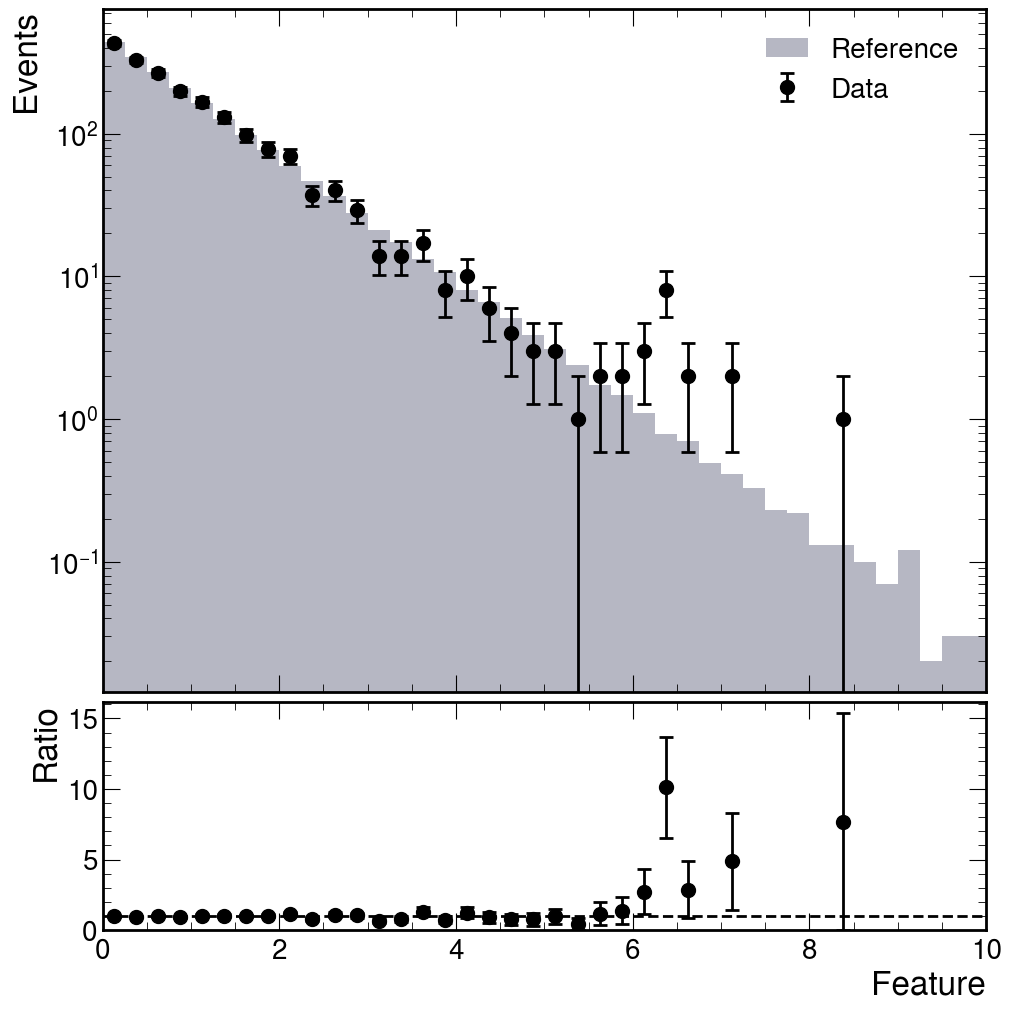

In [9]:
plot_ref_data(
    feature_ref   = feature[target[:, 0] == 0],
    feature_data  = feature[target[:, 0] == 1],
    weights_ref   = target[target[:, 0] == 0, 1],
    weights_data  = target[target[:, 0] == 1, 1],
    figsize       = FIGSIZE,
    bins          = bins,
    ratio         = True,
    fontsize      = FONTSIZE,
    cms           = False,
    color_ref     = PALETTE_2[0],
    color_data    = "black",
    ref_hist_type = "stepfilled",
    ref_label     = "Reference",
    data_label    = "Data",
    ref_alpha     = 0.4,
    xlabel        = "Feature",
    ylabel        = "Events",
    ratio_ylabel  = "Ratio",
    hist_yscale   = "log",
    ratio_yscale  = "linear",
    show_plot     = True,
    save_plot     = False,
    return_fig    = False
)


### Create NPLM model

In [10]:
nplm_model = NPLMnetwork(
    architecture      = ARCHITECTURE,
    activation_func   = ACTIVATION,
    weight_clip_value = WCLIP,
    trainable         = True,
    device            = device
).to(device)

optimizer = torch.optim.Adam(nplm_model.parameters(), lr=0.001)

In [11]:
dof = compute_df(ARCHITECTURE)
print(dof)

13


### Train NPLM model

In [12]:
nplm_model.train_model(
    feature       = feature,
    target        = target,
    loss_function = loss_function,
    optimizer     = optimizer,
    n_epochs      = N_EPOCHS,
    patience      = PATIENCE,
)

Epoch 5000/200000 - Loss: -1.1532
Epoch 10000/200000 - Loss: -1.6489
Epoch 15000/200000 - Loss: -5.1093
Epoch 20000/200000 - Loss: -8.0055
Epoch 25000/200000 - Loss: -10.6196
Epoch 30000/200000 - Loss: -12.2986
Epoch 35000/200000 - Loss: -13.2964
Epoch 40000/200000 - Loss: -13.9959
Epoch 45000/200000 - Loss: -14.5520
Epoch 50000/200000 - Loss: -15.0481
Epoch 55000/200000 - Loss: -15.5121
Epoch 60000/200000 - Loss: -15.9320
Epoch 65000/200000 - Loss: -16.2887
Epoch 70000/200000 - Loss: -16.5561
Epoch 75000/200000 - Loss: -16.6983
Epoch 80000/200000 - Loss: -16.7881
Epoch 85000/200000 - Loss: -16.8625
Epoch 90000/200000 - Loss: -16.9009
Epoch 95000/200000 - Loss: -16.9010
Epoch 100000/200000 - Loss: -16.9010
Epoch 105000/200000 - Loss: -16.9010
Epoch 110000/200000 - Loss: -16.9010
Epoch 115000/200000 - Loss: -16.9010
Epoch 120000/200000 - Loss: -16.9010
Epoch 125000/200000 - Loss: -16.9010
Epoch 130000/200000 - Loss: -16.9009
Epoch 135000/200000 - Loss: -16.9010
Epoch 140000/200000 - Los

### Loss function plot

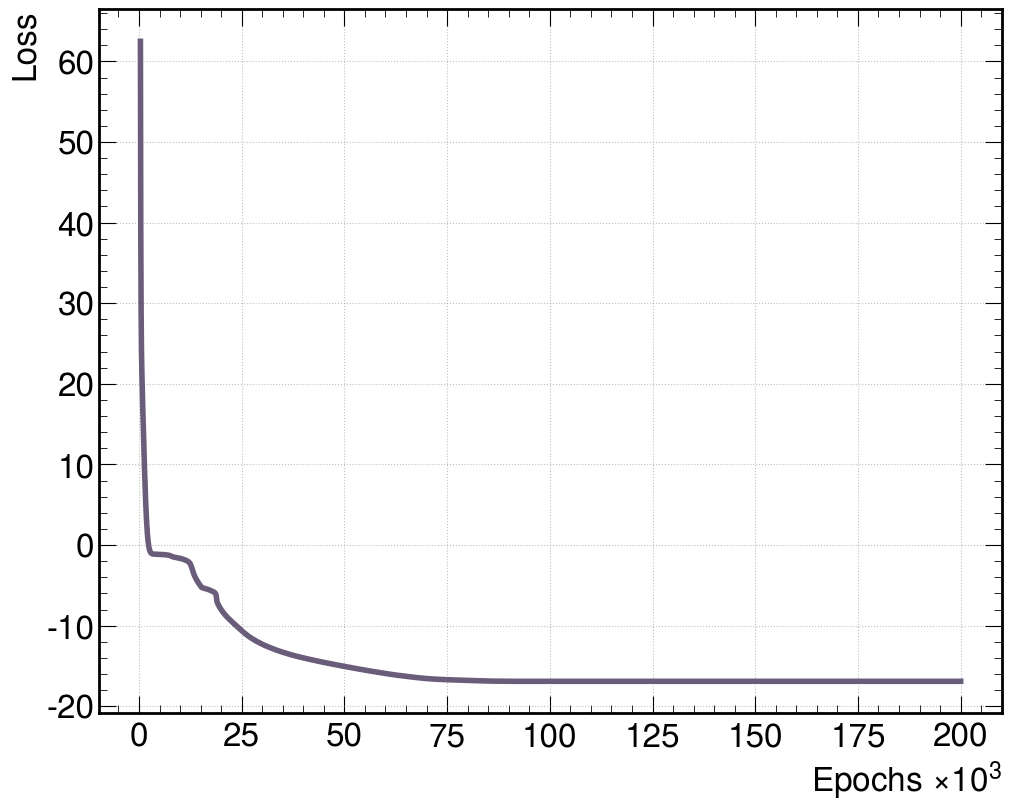

In [13]:
plot_loss_history(
    n_epochs     = N_EPOCHS,
    loss_history = nplm_model.get_losses(),
    epochs_init  = 350,
    epochs_norm  = 1000,
    figsize      = FIGSIZE,
    fontsize     = FONTSIZE,
    cms          = False,
    color        = PALETTE_2[1],
    xlabel       = r"Epochs $\times 10^3$",
    ylabel       = "Loss",
    show_plot    = True,
    save_plot    = False,
    plot_name    = "1dexpon_loss_history",
    plot_path    = PLOT_PATH,
    plot_format  = "png",
    return_fig   = False
)

### Reconstruction

In [14]:
xgrid = torch.arange(bins[0], bins[-1]+0.01, 0.01).to(device)

with torch.no_grad():
    pred = nplm_model(feature[target[:, 0] == 0].to(device))
    grid_pred = nplm_model(xgrid.view(-1, 1))

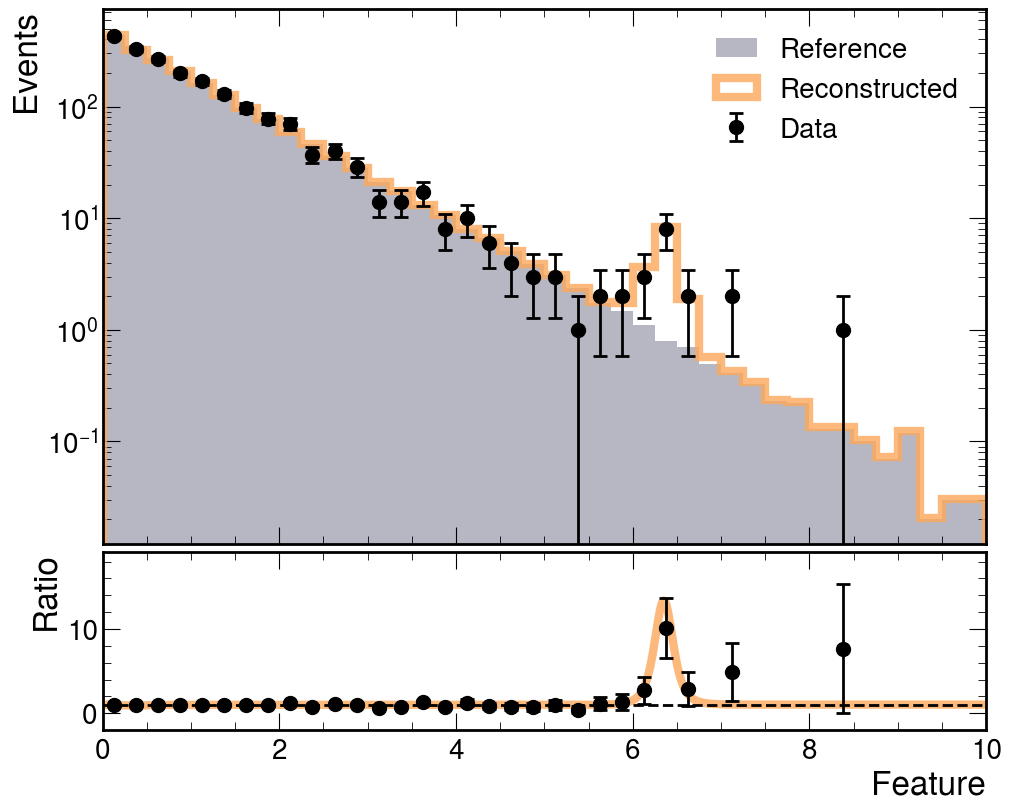

In [15]:
plot_ref_data_reco(
    feature_ref    = feature[target[:, 0] == 0].cpu(),
    feature_data   = feature[target[:, 0] == 1].cpu(),
    weights_ref    = target[target[:, 0] == 0, 1].cpu(),
    weights_data   = target[target[:, 0] == 1, 1].cpu(),
    prediction_ref = pred.cpu(),
    figsize        = FIGSIZE,
    bins           = bins,
    ratio          = True,
    fontsize       = FONTSIZE,
    cms            = False,
    color_ref      = PALETTE_2[0],
    color_data     = "black",
    ref_hist_type  = "stepfilled",
    pred_hist_type = "step",
    ref_label      = "Reference",
    data_label     = "Data",
    ref_alpha      = 0.4,
    color_reco     = PALETTE_2[4],
    reco_label     = "Reconstructed",
    lw_reco        = 6,
    alpha_reco     = 0.8,
    xlabel         = "Feature",
    ylabel         = "Events",
    ratio_ylabel   = "Ratio",
    hist_yscale    = "log",
    ratio_yscale   = "linear",
    show_plot      = True,
    save_plot      = False,
    plot_name      = "1dexpon_reco_binned_bayesianblocks",
    plot_path      = PLOT_PATH,
    plot_format    = "png",
    return_fig     = False,
    binned_reco    = False,
    grid_reco      = xgrid.cpu(),
    grid_pred      = grid_pred.cpu().detach().numpy(),
)